In [1]:
! pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.2 MB/s eta 0:00:00


In [2]:
! git clone https://github.com/2dust/v2rayng
! git clone https://github.com/233boy/v2ray
! git clone https://github.com/521xueweihan/hellogithub

Cloning into 'v2rayng'...
remote: Enumerating objects: 18316, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 18316 (delta 161), reused 93 (delta 93), pack-reused 18105 (from 3)
Receiving objects: 100% (18316/18316), 259.59 MiB | 41.50 MiB/s, done.
Resolving deltas: 100% (11334/11334), done.
Cloning into 'v2ray'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1258 (delta 2), reused 0 (delta 0), pack-reused 1250 (from 3)
Receiving objects: 100% (1258/1258), 1016.11 KiB | 2.70 MiB/s, done.
Resolving deltas: 100% (778/778), done.
Cloning into 'hellogithub'...
remote: Enumerating objects: 5404, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 5404 (delta 407), reused 356 (delta 347), pack-reused 4842 (from 4)
Receiving objects: 100% (5404/5404), 9.42 M

In [7]:
import pandas as pd
from pydriller import Repository
import subprocess

repos = [
    "/content/hellogithub",
    "/content/v2ray",
    "/content/v2rayng"
]

rows = []

for repo in repos:
    for commit in Repository(path_to_repo=repo).traverse_commits():
        for m in commit.modified_files: # works fine with Repository
            if m.old_path and m.new_path:  # skip adds/deletes
                parent = commit.parents[0] if commit.parents else None
                if parent:
                    # Run git diff (Myers default)
                    diff_myers = subprocess.getoutput(
                        f"git -C {repo} diff {parent} {commit.hash} -- {m.new_path} --ignore-blank-lines --ignore-space-at-eol"
                    )

                    # Run git diff (Histogram)
                    diff_hist = subprocess.getoutput(
                        f"git -C {repo} diff --diff-algorithm=histogram {parent} {commit.hash} -- {m.new_path} --ignore-blank-lines --ignore-space-at-eol"
                    )

                    rows.append({
                        "old_file_path": m.old_path,
                        "new_file_path": m.new_path,
                        "commit_SHA": commit.hash,
                        "parent_commit_SHA": parent,
                        "commit_message": commit.msg,
                        "diff_myers": diff_myers,
                        "diff_hist": diff_hist,
                        "Discrepancy": "No" if diff_myers == diff_hist else "Yes"
                    })

# Save dataset
df = pd.DataFrame(rows)
df.to_csv("diff_dataset.csv", index=False)
df.head()


,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_myers,diff_hist,Discrepancy
0,01/img/Archey for OS X.png,01/img/Archey for OS X.png,7e283099e2900f5117d67cd99910470cc8f6892e,9bfe38ad37b517777b9d56a8d89034f594f080f3,项目瘦身100M->200K,,,No
1,01/img/TuShare.png,01/img/TuShare.png,7e283099e2900f5117d67cd99910470cc8f6892e,9bfe38ad37b517777b9d56a8d89034f594f080f3,项目瘦身100M->200K,diff --git a/01/img/TuShare.png b/01/img/TuSha...,diff --git a/01/img/TuShare.png b/01/img/TuSha...,No
2,01/img/TuShare2.png,01/img/TuShare2.png,7e283099e2900f5117d67cd99910470cc8f6892e,9bfe38ad37b517777b9d56a8d89034f594f080f3,项目瘦身100M->200K,diff --git a/01/img/TuShare2.png b/01/img/TuSh...,diff --git a/01/img/TuShare2.png b/01/img/TuSh...,No
3,01/img/VeryNginx.jpeg,01/img/VeryNginx.jpeg,7e283099e2900f5117d67cd99910470cc8f6892e,9bfe38ad37b517777b9d56a8d89034f594f080f3,项目瘦身100M->200K,diff --git a/01/img/VeryNginx.jpeg b/01/img/Ve...,diff --git a/01/img/VeryNginx.jpeg b/01/img/Ve...,No
4,01/img/activate-power-mode.gif,01/img/activate-power-mode.gif,7e283099e2900f5117d67cd99910470cc8f6892e,9bfe38ad37b517777b9d56a8d89034f594f080f3,项目瘦身100M->200K,diff --git a/01/img/activate-power-mode.gif b/...,diff --git a/01/img/activate-power-mode.gif b/...,No


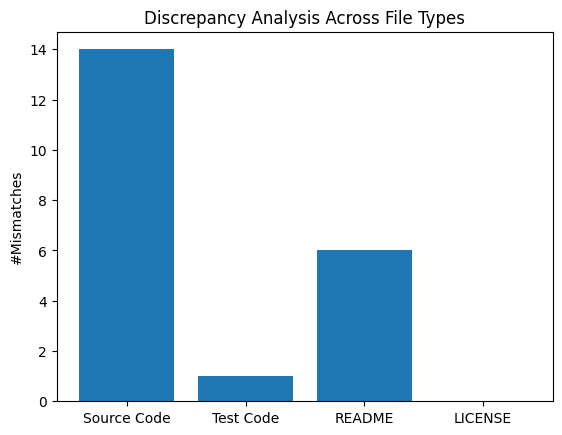

In [9]:
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("diff_dataset.csv")

# Filters
source_code = df[df['new_file_path'].str.endswith(('.py', '.java', '.c', '.cpp', '.kts', '.sh', '.js'))]
tests = df[df['new_file_path'].str.contains("test", case=False, na=False)]
readme = df[df['new_file_path'].str.contains("README", case=False, na=False)]
license_f = df[df['new_file_path'].str.contains("LICENSE", case=False, na=False)]

# Count mismatches
stats = {
    "Source Code": (source_code['Discrepancy'] == "Yes").sum(),
    "Test Code": (tests['Discrepancy'] == "Yes").sum(),
    "README": (readme['Discrepancy'] == "Yes").sum(),
    "LICENSE": (license_f['Discrepancy'] == "Yes").sum(),
}

# Plot
plt.bar(stats.keys(), stats.values())
plt.ylabel("#Mismatches")
plt.title("Discrepancy Analysis Across File Types")
plt.show()
